## Connecting to Drive

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# change to the path pointing the this shared folder in your drive
%cd /content/drive/MyDrive/HW3_DL

/content/drive/MyDrive/HW3_DL


## Libraries

In [11]:
import numpy as np
import os
import collections
from copy import deepcopy
from numpy.core.numeric import indices
import torch
import pandas as pd
from torch.utils.data.sampler import Sampler, SequentialSampler, BatchSampler

# Set for constant results
seed = 0
torch.manual_seed(seed)

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vae_binomial_train_sample = True
svm_test_show_figure = False
show_loss_plots = True

# Functions

In [13]:
# Creates normally randomized torch parameters
def rand_param(size, std=1e-2):
    is_2d = len(size) == 2 and size[1] > 1
    std = 1.0 if is_2d else std
    data = torch.distributions.Normal(loc=0.0, scale=std).sample(size)

    if is_2d:
        data /= np.sqrt(size[1])

    return nn.Parameter(torch.Tensor(data))


# Creates normally zeroed torch parameters
def zeros_param(size):
    return nn.Parameter(torch.Tensor(torch.zeros(size)))


class VAE(nn.Module):
    '''
    Variational Autoencoder
    '''
    def __init__(self, n_x, n_z, hidden_size):
        super().__init__()

        self.hidden_size = hidden_size
        self.n_x = n_x
        self.n_z = n_z
        self.log_2pi = torch.scalar_tensor(np.log(2 * np.pi))

        self.init_weights()

    def init_weights(self):
        # Assuming 2 hidden layers

        # self.v_* parameters refer to encoder part
        self.v_w0 = rand_param((self.hidden_size, self.n_x))
        self.v_b0 = rand_param((self.hidden_size, 1))
        self.v_w1 = rand_param((self.hidden_size, self.hidden_size))
        self.v_b1 = rand_param((self.hidden_size, 1))
        self.v_mean_w = rand_param((self.n_z, self.hidden_size))
        self.v_mean_b = rand_param((self.n_z, 1))
        self.v_logvar_w = zeros_param((self.n_z, self.hidden_size))
        self.v_logvar_b = zeros_param((self.n_z, 1))

        # self.w_* parameters refer to encoder part
        self.w_w0 = rand_param((self.hidden_size, self.n_z))
        self.w_b0 = rand_param((self.hidden_size, 1))
        self.w_w1 = rand_param((self.hidden_size, self.hidden_size))
        self.w_b1 = rand_param((self.hidden_size, 1))
        self.w_out_w = rand_param((self.n_x, self.hidden_size))
        self.w_out_b = zeros_param((self.n_x, 1))

    def encoder(self, x):
        x = x.reshape(x.shape[0], self.n_x).transpose(1, 0)
        A = self.get_A(x)

        # Compute q(z|x)
        hidden_q = [x]
        hidden_q.append(F.softplus(self.v_w0.mm(hidden_q[0]) + self.v_b0.mm(A)))
        hidden_q.append(F.softplus(self.v_w1.mm(hidden_q[1]) + self.v_b1.mm(A)))

        q_mean = self.v_mean_w.mm(hidden_q[-1]) + self.v_mean_b.mm(A)
        q_logvar = self.v_logvar_w.mm(hidden_q[-1]) + self.v_logvar_b.mm(A)

        # Compute virtual sample
        eps = torch.randn(size=q_mean.shape, device=device)
        z = q_mean + (0.5 * q_logvar).exp() * eps
        return x, A, z, q_mean, q_logvar

    def decoder(self, x, A, z):
        # Compute log p(x|z)
        hidden_p = [z]
        hidden_p.append(F.softplus(self.w_w0.mm(hidden_p[0]) + self.w_b0.mm(A)))
        hidden_p.append(F.softplus(self.w_w1.mm(hidden_p[1]) + self.w_b1.mm(A)))

        x_hat = torch.sigmoid(self.w_out_w.mm(hidden_p[-1]) + self.w_out_b.mm(A))
        return x_hat

    def calc_loss(self, x, x_hat, q_mean, q_logvar):
        _logpx = - F.binary_cross_entropy(x_hat, x, reduction='none')

        # Note: logpx is a row vector (one element per sample)
        # logpx = log p(x|z,w)
        logpx = torch.ones(size=(1, self.n_x), device=device).mm(_logpx)

        # log p(z) (prior of z)
        logpz = -0.5 * (self.log_2pi + (q_mean**2 + q_logvar.exp())).sum(axis=0, keepdims=True)

        # loq q(z|x) (entropy of z)
        logqz = -0.5 * (self.log_2pi + 1 + q_logvar).sum(axis=0, keepdims=True)

        logpx, logpz, logqz
        loss = logpx + logpz - logqz
        return loss

    def get_A(self, x):
        return torch.ones(size=(1, x.shape[1]), device=device)

    def forward(self, x: torch.Tensor):
        x, A, z, q_mean, q_logvar = self.encoder(x)
        x_hat = self.decoder(x, A, z)
        loss = self.calc_loss(x, x_hat, q_mean, q_logvar)
        return loss


class SVM(nn.Module):
    '''
    Linear Support Vector Machine
    Used for multi-class classification using the one-to-rest method approach.
    '''
    def __init__(self, n_z, hidden_size=0):
        super().__init__()
        self.n_z = n_z
        self.hidden_size = hidden_size
        self.init_weights()

    def init_weights(self):
        if self.hidden_size == 0:
            # Assuming no hidden layers
            self.w_out = rand_param((1, self.n_z))
            self.b_out = rand_param((1, 1))
        else:
            # Assuming 2 hidden layers
            self.w0 = rand_param((self.hidden_size, self.n_z))
            self.b0 = rand_param((self.hidden_size, 1))
            self.w1 = rand_param((self.hidden_size, self.hidden_size))
            self.b1 = rand_param((self.hidden_size, 1))
            self.w_out = rand_param((1, self.hidden_size))
            self.b_out = rand_param((1, 1))

    def forward(self, z: torch.Tensor):
        A = torch.ones(size=(1, z.shape[1]), device=device)
        if self.hidden_size == 0:
            score = self.w_out.mm(z) + self.b_out.mm(A)
        else:
            hidden = [z]
            hidden.append(torch.sigmoid(self.w0.mm(hidden[0]) + self.b0.mm(A)))
            hidden.append(torch.sigmoid(self.w1.mm(hidden[1]) + self.b1.mm(A)))
            score = torch.sigmoid(self.w_out.mm(hidden[2]) + self.b_out.mm(A))
        return score


class MultiClassSVM(nn.Module):
    '''
    Multi-class SVM
    Used for multi-class classification using the one-to-rest method approach.
    '''
    def __init__(self, n_z, n_y, poly_degree=1):
        super().__init__()
        self.n_z = n_z
        self.n_y = n_y
        self.poly_degree = poly_degree
        self.SVMs = nn.ModuleList([SVM(n_z * poly_degree, hidden_size=0)
                                   for _ in range(self.n_y)])

    def forward(self, z: torch.Tensor):
        if self.poly_degree > 1:
            z = [z]
            for i in range(self.poly_degree - 1):
                z.append(z[-1] * z[0])
            z = torch.cat(z)
        # Run all the SVMs on all the batch images
        scores = torch.stack([self.SVMs[i](z).flatten()
                              for i in range(self.n_y)], dim = 1)
        return scores

    @staticmethod
    def calculate_y_hat(scores: torch.Tensor):
        return scores.argmax(dim=1)

    @staticmethod
    def calc_loss(scores, y: torch.Tensor):
        '''
        Hinge loss:

        for j = 0:N (j != y)
            L = sigma(max(0, Sj - Sy + 1))

        Where S is the score of each individual SVM and Sj is the currently
        iterated SVM.
        '''
        y = y.long().unsqueeze(1)
        truth_scores = scores.gather(1, y)
        loss_per_SVM = scores - truth_scores + 1
        loss_per_SVM[torch.where(loss_per_SVM < 0)] = 0
        # Use '- 1' to compenstate for the truth score being
        total_loss = loss_per_SVM.sum(dim=1) - 1
        return total_loss


class BalancedSampler(SequentialSampler):
    def __init__(self, data_source):
        super().__init__(data_source)
        self.num_classes = len(self.data_source.classes)

        # Select all indices of all classes
        indices = [(data_source.targets == i).nonzero(as_tuple=True)[0]
                    for i in range(self.num_classes)]

        # shuffle all
        indices = [indices[i][torch.randperm(indices[i].shape[0])]
                   for i in range(len(indices))]

        # turn all to dequeues for easier iteration
        self.index_deques = [collections.deque(indices[i].tolist())
                             for i in range(len(indices))]

    def __len__(self):
        return len(self.data_source)

    def __iter__(self):
        dequeues = deepcopy(self.index_deques)
        more_data = True
        while more_data:
            for i in range(self.num_classes):
                if len(dequeues[i]) == 0:
                    more_data = False
                    break
                yield dequeues[i].pop()


class BalancedBatchSampler(BatchSampler):
    def __init__(self, sampler: Sampler[int], batch_size: int, max_size: int):
        super().__init__(sampler, batch_size, drop_last=True)
        self.max_size = min(max_size, len(sampler))
        self.batch_size = min(self.max_size, self.batch_size)

    def __len__(self):
        return self.max_size // self.batch_size

    def _shuffle_batch(self, batch):
        batch = torch.Tensor(batch).long()
        return batch[torch.randperm(batch.shape[0])].tolist()

    def __iter__(self):
        batch = []
        remaining = len(self)
        for idx in self.sampler:
            batch.append(idx)
            if len(batch) == self.batch_size:
                yield self._shuffle_batch(batch)
                batch = []
                remaining -= 1
                if remaining == 0:
                    break


def vae_train(vae: VAE, vae_optimizer: optim.Adam, train_loader, epochs=20):
    vae.train()
    loss_VAE_plot=[]

    for epoch in range(epochs):
        train_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            if vae_binomial_train_sample:
                x = torch.Tensor(np.random.binomial(n=1, p=x).astype(np.float32))

            x = x.to(device)
            vae_optimizer.zero_grad()
            loss: torch.Tensor = vae(x).sum()
            (-loss).backward()
            train_loss += loss.item()
            vae_optimizer.step()

            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(x), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item() / len(x)))
        print('====> Epoch: {} Average loss: {:.4f}'.
              format(epoch, train_loss / len(train_loader.dataset)))
        loss_VAE_plot.append(train_loss / len(train_loader.dataset))
    return loss_VAE_plot


def vae_test(vae: VAE, test_loader):
    vae.eval()
    test_loss = 0
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            loss = vae(x).sum()
            test_loss += loss.item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set VAE loss: {:.4f}'.format(test_loss))


def svm_train(vae: VAE, svm: MultiClassSVM, svm_optimizer: optim.SGD,
              train_loader, epochs=20):
    svm.train()
    vae.eval()

    loss_plot=[]
    for epoch in range(epochs):
        train_loss = 0
        total_items = 0
        for batch_idx, (x, y) in enumerate(train_loader):
            x = x.to(device)
            y = y.to(device)
            _, _, z, _, _ = vae.encoder(x)
            svm_optimizer.zero_grad()
            scores = svm(z)
            loss = MultiClassSVM.calc_loss(scores, y).sum()
            loss.backward()
            svm_optimizer.step()
            train_loss += loss.item()
            total_items += len(x)

            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(x), len(train_loader),
                    100. * batch_idx / len(train_loader), loss.item() / len(x)))

        print('====> Epoch: {} Average loss: {:.4f}'.
              format(epoch, train_loss / total_items))
        loss_plot.append(train_loss / total_items)
    return loss_plot


def im_convert(tensor):
    image=tensor.clone().detach().cpu().numpy()
    image=image.transpose(1,2,0)
    image=image*(np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5)))
    image=image.clip(0,1)
    return image


def svm_test(vae: VAE, svm: MultiClassSVM, test_loader):
    svm.eval()
    vae.eval()

    test_loss = 0
    total_items = 0
    accurate_results = 0
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            _, _, z, _, _ = vae.encoder(x)
            scores = svm(z)
            loss = MultiClassSVM.calc_loss(scores, y).sum()
            test_loss += loss.item()
            total_items += len(x)

            y_hat = MultiClassSVM.calculate_y_hat(scores)
            accurate_results += (y_hat == y).sum().item()
            if svm_test_show_figure:
                fig = plt.figure(figsize=(25,4))
                fig.suptitle('Inferred Labels (Real Labels)', fontsize=16)
                for idx in np.arange(20):
                    ax = fig.add_subplot(2,10,idx+1)
                    plt.imshow(im_convert(x[idx]))
                    ax.set_title('{} ({})'.format(y_hat[idx].item(), y[idx].item()))
                plt.show()

    test_loss /= total_items
    print('====> Test set SVM loss: {:.4f}'.format(test_loss))

    accuracy = (accurate_results / total_items) * 100.0
    print("====> SVM Test accuracy: "
          f"{accurate_results} / {total_items} = {accuracy}%")
    return accuracy

### Main Function

Main function for running VAE feature extractor and SVM classifier.
    'svm_train_n_labels' sets the total size of labels for the SVM classifier
                         to train upon. Tested for: 100, 600, 1000, 3000.
    'models_path' sets the folder to load/save the models from/to.
    'vae_load'/'svm_load' loads the models from a file instead of training them.
    'vae_save'/'svm_save' saves the models, if trained.
    'dataset' can be either 'mnist' or 'fashion_mnist'

In [14]:
def main(svm_train_n_labels=3000, models_path='./models',
         vae_load=True, svm_load=True, vae_save=True, svm_save=True,
         dataset='fashion_mnist'):

    # Create models folder, if doesn't exist
    if not os.path.exists(models_path):
        os.mkdir(models_path)

    n_y = 10
    n_z = 50
    hidden_size = 500
    n_batch = 1000 # size of each batch

    # VAE parameters
    vae_path = os.path.join(models_path, 'vae_model')
    vae_opt_eps = 1e-10
    n_vae_epochs = 20
    vae_learning_rate = 3e-4

    # SVM parameters
    svm_path = os.path.join(models_path, 'svm_model')
    n_svm_epochs = 20
    svm_learning_rate = 0.001

    # Select the dataset
    if dataset == 'mnist':
        train_dataset = datasets.MNIST(root='./mnist_data/', train=True,
                                    transform=transforms.ToTensor(), download=True)
        test_dataset = datasets.MNIST(root='./mnist_data/', train=False,
                                    transform=transforms.ToTensor(), download=False)
    elif dataset == 'fashion_mnist':
        train_dataset = datasets.FashionMNIST(root='./fashion_mnist_data/', train=True,
                                            transform=transforms.ToTensor(), download=True)
        test_dataset = datasets.FashionMNIST(root='./fashion_mnist_data/', train=False,
                                            transform=transforms.ToTensor(), download=False)

    train_data: torch.Tensor = train_dataset.data

    # Data inferred parameters
    n_train = train_data.shape[0] # 60000
    n_x = train_data.shape[1] * train_data.shape[2] # 28 * 28
    weight_decay = float(n_batch) / n_train
    svm_weight_decay = float(min(n_batch, svm_train_n_labels)) / svm_train_n_labels

    # Data Loader (Input Pipeline)
    vae_train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                batch_size=n_batch,
                                                shuffle=True)
    batch_sampler = BalancedBatchSampler(BalancedSampler(train_dataset),
                                        batch_size=n_batch,
                                        max_size=svm_train_n_labels)
    svm_train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                batch_sampler=batch_sampler)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=n_batch, shuffle=False)


    # Build VAE and SVM models and optimizers
    vae = VAE(n_x=n_x, n_z=n_z, hidden_size=hidden_size).to(device)
    vae_optimizer = optim.Adam(vae.parameters(), lr=vae_learning_rate, eps=vae_opt_eps,
                            betas=(0.9, 0.999), weight_decay=weight_decay)
    svm = MultiClassSVM(n_z=n_z, n_y=n_y).to(device)
    svm_optimizer = optim.SGD(svm.parameters(), lr=svm_learning_rate, momentum=0.9,
                            weight_decay=svm_weight_decay)

    # Train VAE (as feature extractor)
    if vae_load and not os.path.exists(vae_path):
        print("VAE model file does not exist, training a new one")
        vae_load = False
    if vae_load:
        print("Loading VAE")
        vae.load_state_dict(torch.load(vae_path))
    else:
        print("Training VAE")
        VAE_train_loss = vae_train(vae, vae_optimizer, vae_train_loader, epochs=n_vae_epochs)

        if vae_save:
            print("Saving VAE")
            torch.save(vae.state_dict(), vae_path)

        if show_loss_plots:
            fig = plt.figure()
            fig.suptitle('VAE loss', fontsize=16)
            plt.plot(VAE_train_loss)
            plt.xlabel("Epochs")
            plt.ylabel("VAETrain Loss %")
            plt.show()


    # Test VAE
    print("Testing VAE")
    vae_test(vae, test_loader)

    # Train SVM (as classifier)
    if svm_load and not os.path.exists(svm_path):
        print("SVM model file does not exist, training a new one")
        svm_load = False
    if svm_load:
        print("Loading SVM")
        svm.load_state_dict(torch.load(svm_path))
    else:
        print("Training SVM")
        svm_train_loss = svm_train(vae, svm, svm_optimizer, svm_train_loader, epochs=n_svm_epochs)

        if svm_save:
            print("Saving SVM")
            torch.save(svm.state_dict(), svm_path)
        if show_loss_plots:
            fig = plt.figure()
            fig.suptitle('svm loss', fontsize=16)
            plt.plot(svm_train_loss)
            plt.xlabel("Epochs")
            plt.ylabel("SVM Train Loss %")
            plt.show()


    # Test VAE + SVM
    print("Testing SVM")
    accuracy = svm_test(vae, svm, test_loader)
    return accuracy

## Results

In [15]:
# Load pre-existing models of both VAE and SVM and run tests.
main(models_path='./drive/MyDrive/models', svm_train_n_labels=3000)

Loading VAE
Testing VAE
====> Test set VAE loss: -254.8668
Loading SVM
Testing SVM
====> Test set SVM loss: 2.0271
====> SVM Test accuracy: 6843 / 10000 = 68.43%


68.43

-------------------- Testing with SVM learning upon 100 labeled images: --------------------
Loading VAE
Testing VAE
====> Test set VAE loss: -254.7946
Training SVM
Train Epoch: 0 [0/1 (0%)]	Loss: 13.547545
====> Epoch: 0 Average loss: 13.5475
Train Epoch: 1 [0/1 (0%)]	Loss: 9.676293
====> Epoch: 1 Average loss: 9.6763
Train Epoch: 2 [0/1 (0%)]	Loss: 4.974927
====> Epoch: 2 Average loss: 4.9749
Train Epoch: 3 [0/1 (0%)]	Loss: 2.808040
====> Epoch: 3 Average loss: 2.8080
Train Epoch: 4 [0/1 (0%)]	Loss: 1.481770
====> Epoch: 4 Average loss: 1.4818
Train Epoch: 5 [0/1 (0%)]	Loss: 1.617268
====> Epoch: 5 Average loss: 1.6173
Train Epoch: 6 [0/1 (0%)]	Loss: 1.273681
====> Epoch: 6 Average loss: 1.2737
Train Epoch: 7 [0/1 (0%)]	Loss: 1.374752
====> Epoch: 7 Average loss: 1.3748
Train Epoch: 8 [0/1 (0%)]	Loss: 1.481482
====> Epoch: 8 Average loss: 1.4815
Train Epoch: 9 [0/1 (0%)]	Loss: 1.118656
====> Epoch: 9 Average loss: 1.1187
Train Epoch: 10 [0/1 (0%)]	Loss: 1.555038
====> Epoch: 10 Avera

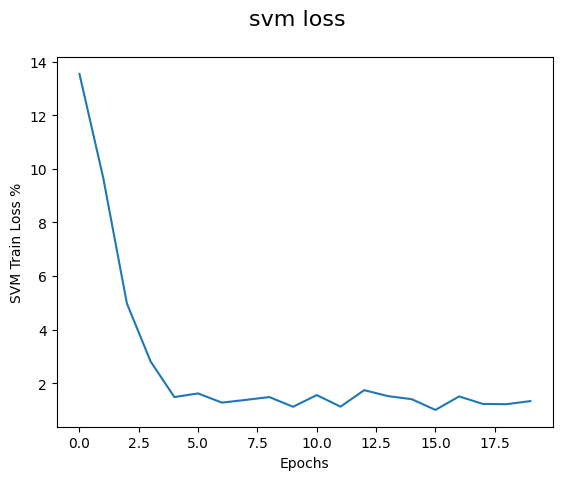

Testing SVM
====> Test set SVM loss: 3.8266
====> SVM Test accuracy: 6128 / 10000 = 61.28%
--------------------



-------------------- Testing with SVM learning upon 600 labeled images: --------------------
Loading VAE
Testing VAE
====> Test set VAE loss: -254.8679
Training SVM
Train Epoch: 0 [0/1 (0%)]	Loss: 10.086653
====> Epoch: 0 Average loss: 10.0867
Train Epoch: 1 [0/1 (0%)]	Loss: 2.369637
====> Epoch: 1 Average loss: 2.3696
Train Epoch: 2 [0/1 (0%)]	Loss: 1.912336
====> Epoch: 2 Average loss: 1.9123
Train Epoch: 3 [0/1 (0%)]	Loss: 2.007557
====> Epoch: 3 Average loss: 2.0076
Train Epoch: 4 [0/1 (0%)]	Loss: 2.132119
====> Epoch: 4 Average loss: 2.1321
Train Epoch: 5 [0/1 (0%)]	Loss: 2.180579
====> Epoch: 5 Average loss: 2.1806
Train Epoch: 6 [0/1 (0%)]	Loss: 2.666395
====> Epoch: 6 Average loss: 2.6664
Train Epoch: 7 [0/1 (0%)]	Loss: 2.673258
====> Epoch: 7 Average loss: 2.6733
Train Epoch: 8 [0/1 (0%)]	Loss: 2.551414
====> Epoch: 8 Average loss: 2.5514
Train Epoch: 9 [0/1 (0%)]

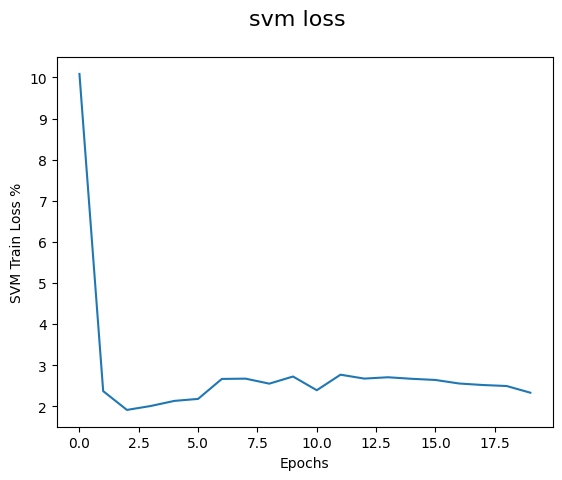

Testing SVM
====> Test set SVM loss: 3.1538
====> SVM Test accuracy: 6682 / 10000 = 66.82000000000001%
--------------------



-------------------- Testing with SVM learning upon 1000 labeled images: --------------------
Loading VAE
Testing VAE
====> Test set VAE loss: -254.8687
Training SVM
Train Epoch: 0 [0/1 (0%)]	Loss: 9.397051
====> Epoch: 0 Average loss: 9.3971
Train Epoch: 1 [0/1 (0%)]	Loss: 2.020300
====> Epoch: 1 Average loss: 2.0203
Train Epoch: 2 [0/1 (0%)]	Loss: 2.376241
====> Epoch: 2 Average loss: 2.3762
Train Epoch: 3 [0/1 (0%)]	Loss: 2.612552
====> Epoch: 3 Average loss: 2.6126
Train Epoch: 4 [0/1 (0%)]	Loss: 2.977682
====> Epoch: 4 Average loss: 2.9777
Train Epoch: 5 [0/1 (0%)]	Loss: 3.273319
====> Epoch: 5 Average loss: 3.2733
Train Epoch: 6 [0/1 (0%)]	Loss: 3.171537
====> Epoch: 6 Average loss: 3.1715
Train Epoch: 7 [0/1 (0%)]	Loss: 3.176269
====> Epoch: 7 Average loss: 3.1763
Train Epoch: 8 [0/1 (0%)]	Loss: 3.426291
====> Epoch: 8 Average loss: 3.4263
Train Epoch: 9

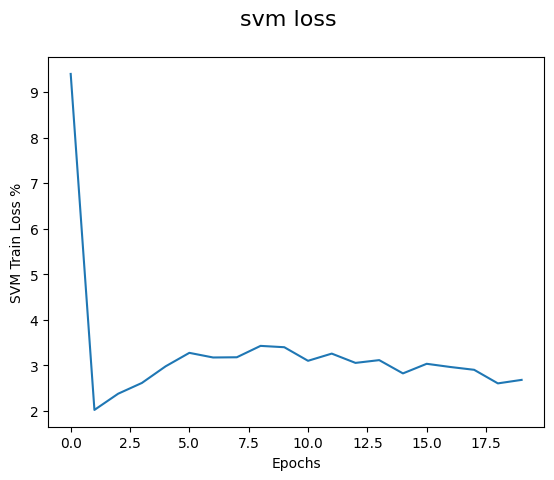

Testing SVM
====> Test set SVM loss: 3.3430
====> SVM Test accuracy: 6813 / 10000 = 68.13%
--------------------



-------------------- Testing with SVM learning upon 3000 labeled images: --------------------
Loading VAE
Testing VAE
====> Test set VAE loss: -254.8674
Training SVM
Train Epoch: 0 [0/3 (0%)]	Loss: 10.478727
====> Epoch: 0 Average loss: 4.9626
Train Epoch: 1 [0/3 (0%)]	Loss: 2.757160
====> Epoch: 1 Average loss: 2.8601
Train Epoch: 2 [0/3 (0%)]	Loss: 3.551728
====> Epoch: 2 Average loss: 3.3361
Train Epoch: 3 [0/3 (0%)]	Loss: 3.959875
====> Epoch: 3 Average loss: 3.4971
Train Epoch: 4 [0/3 (0%)]	Loss: 3.628443
====> Epoch: 4 Average loss: 3.3842
Train Epoch: 5 [0/3 (0%)]	Loss: 3.712987
====> Epoch: 5 Average loss: 3.2600
Train Epoch: 6 [0/3 (0%)]	Loss: 3.572238
====> Epoch: 6 Average loss: 3.1156
Train Epoch: 7 [0/3 (0%)]	Loss: 3.435776
====> Epoch: 7 Average loss: 2.9462
Train Epoch: 8 [0/3 (0%)]	Loss: 3.419194
====> Epoch: 8 Average loss: 2.9135
Train Epoch: 9 [0/3 (0%)]

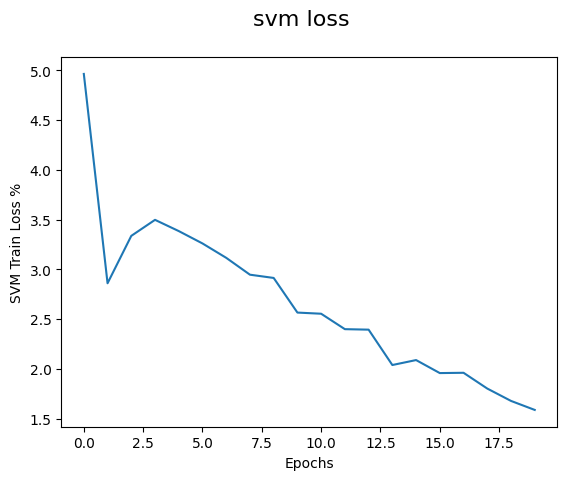

Testing SVM
====> Test set SVM loss: 1.8381
====> SVM Test accuracy: 7003 / 10000 = 70.03%
--------------------





In [16]:
# Load VAE, train SVM on different numbers of labels and run tests.
accuracies = []
Num_Labels = [100, 600, 1000, 3000]
for num in Num_Labels:
    print(f"{'-'*20} Testing with SVM learning upon {num} labeled images: {'-'*20}")
    score = main(models_path='./drive/MyDrive/models', svm_train_n_labels=num, svm_load=False)
    accuracies.append(score)
    print(f"{'-'*20}\n\n\n")

Training VAE
Train Epoch: 0 [0/60000 (0%)]	Loss: -647.038563
====> Epoch: 0 Average loss: -408.0507
Train Epoch: 1 [0/60000 (0%)]	Loss: -347.583062
====> Epoch: 1 Average loss: -318.2475
Train Epoch: 2 [0/60000 (0%)]	Loss: -313.860313
====> Epoch: 2 Average loss: -300.2019
Train Epoch: 3 [0/60000 (0%)]	Loss: -290.299469
====> Epoch: 3 Average loss: -286.6604
Train Epoch: 4 [0/60000 (0%)]	Loss: -281.800750
====> Epoch: 4 Average loss: -277.0965
Train Epoch: 5 [0/60000 (0%)]	Loss: -273.866125
====> Epoch: 5 Average loss: -272.5239
Train Epoch: 6 [0/60000 (0%)]	Loss: -264.421938
====> Epoch: 6 Average loss: -269.5064
Train Epoch: 7 [0/60000 (0%)]	Loss: -265.150656
====> Epoch: 7 Average loss: -266.8996
Train Epoch: 8 [0/60000 (0%)]	Loss: -266.652719
====> Epoch: 8 Average loss: -264.7551
Train Epoch: 9 [0/60000 (0%)]	Loss: -263.377313
====> Epoch: 9 Average loss: -262.7594
Train Epoch: 10 [0/60000 (0%)]	Loss: -265.939687
====> Epoch: 10 Average loss: -261.1008
Train Epoch: 11 [0/60000 (0%

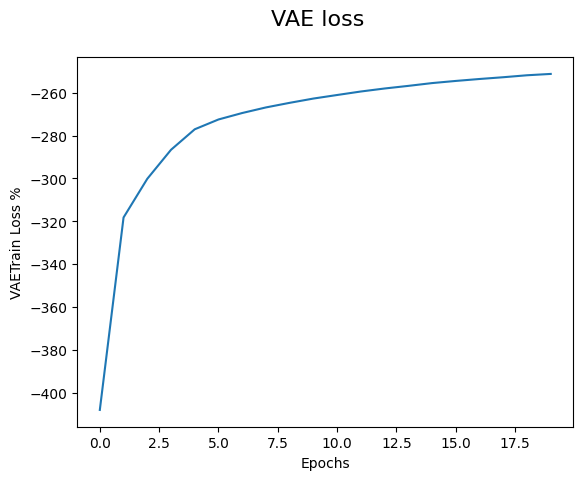

Testing VAE
====> Test set VAE loss: -254.8068
Training SVM
Train Epoch: 0 [0/3 (0%)]	Loss: 10.535076
====> Epoch: 0 Average loss: 5.1643
Train Epoch: 1 [0/3 (0%)]	Loss: 2.902996
====> Epoch: 1 Average loss: 3.1055
Train Epoch: 2 [0/3 (0%)]	Loss: 3.114197
====> Epoch: 2 Average loss: 3.4873
Train Epoch: 3 [0/3 (0%)]	Loss: 3.643913
====> Epoch: 3 Average loss: 3.7272
Train Epoch: 4 [0/3 (0%)]	Loss: 3.572014
====> Epoch: 4 Average loss: 3.5453
Train Epoch: 5 [0/3 (0%)]	Loss: 3.282373
====> Epoch: 5 Average loss: 3.3898
Train Epoch: 6 [0/3 (0%)]	Loss: 3.146043
====> Epoch: 6 Average loss: 3.3109
Train Epoch: 7 [0/3 (0%)]	Loss: 3.153694
====> Epoch: 7 Average loss: 3.1568
Train Epoch: 8 [0/3 (0%)]	Loss: 3.069252
====> Epoch: 8 Average loss: 2.9981
Train Epoch: 9 [0/3 (0%)]	Loss: 2.573293
====> Epoch: 9 Average loss: 2.7127
Train Epoch: 10 [0/3 (0%)]	Loss: 2.441964
====> Epoch: 10 Average loss: 2.6257
Train Epoch: 11 [0/3 (0%)]	Loss: 2.481652
====> Epoch: 11 Average loss: 2.4275
Train Epoch

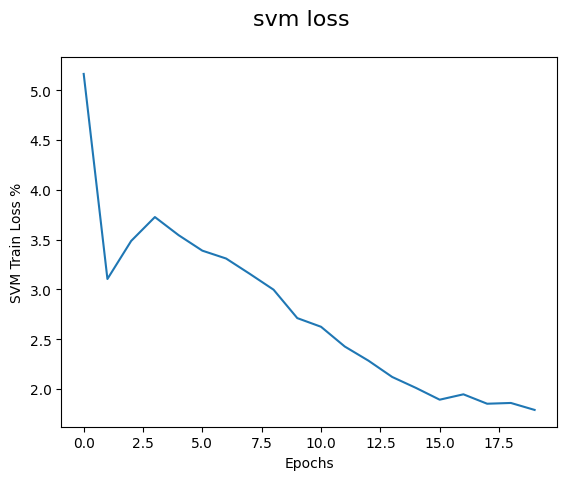

Testing SVM
====> Test set SVM loss: 1.9812
====> SVM Test accuracy: 6813 / 10000 = 68.13%


68.13

In [17]:
# Train both VAE and SVM and run tests.
main(models_path='./drive/MyDrive/models', svm_train_n_labels=3000, vae_load=False, svm_load=False)

In [18]:
data = {
  "Num Labels": Num_Labels,
  "Accuracies": accuracies}

#load data into a DataFrame object:
df = pd.DataFrame(data)
df

,Num Labels,Accuracies
0,100,61.28
1,600,66.82
2,1000,68.13
3,3000,70.03
